<img src="../images/portada_3.png"/>
Developed by M.Rovai @ May, 13 2020<br>

Based on the word of [Adrian Rosebrock](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) and [Nell Trevor](https://www.kaggle.com/mauddib/covid-19-x-ray-deep-learning-api-endpoint-code)


# Covid-19 vs Pneumo Xray Detection
---

## Disclaimer

The deployment of an automatic COVID-19 detection is for educational purposes only. It is not meant to be a reliable, highly accurate COVID-19 diagnosis system, nor has it been professionally or academically vetted.

## Introduction

**Inspiration**

The inspiration of this project, was to understand and create a didactic proof of concept of the work "[XRayCovid-19](http://tools.atislabs.com.br/covid)" developed by UFRRJ (Universidade Federal Rural do Rio de Janiero). **XRayCovid-19** is an ongoing project that uses Artificial Intelligence to assist the health system in the COVID-19 diagnostic process. It is characterized by easy use; efficiency in response time and effectiveness in the result.

**Why X-rays?**

There have been promising efforts to apply machine learning to aid in the diagnosis of COVID-19 based on CT scans. Despite the success of these methods, the fact remains that COVID-19 is an infection that is likely to be experienced by communities of all sizes. X-rays are inexpensive and quick to perform; therefore, they are more accessible to healthcare providers working in smaller and/or remote regions. 

**Thanks**

This work was developed using TensorFlow and Keras, based on the great tutorial published by [Dr. Adrian Rosebrock](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/). Also, I would like to thanks Nell Trevor that, also based on Dr. Rosebrock's work, provided an endpoint idea, where the resultant model could be tested: [Covid-19 predictor API](http://coviddetector.pythonanywhere.com)

## Papers

- [[1] 2020 Chowdhury et al - Can AI help in screening Viral and COVID-19 pneumonia?](https://arxiv.org/pdf/2003.13145.pdf)
- [[2] 2020 Hall et all - Finding COVID-19 from Chest X-rays using Deep Learning on a Small Dataset](https://arxiv.org/pdf/2004.02060.pdf)
- [[3] 2020 COVID-19 Screening on Chest X-ray Images Using Deep Learning based Anomaly Detection](https://arxiv.org/pdf/2003.12338.pdf)

## Import Libraries and Setup

In [1]:
import os
import datetime
import random
import statistics as stat
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
import cv2
from imutils import paths

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

## Support Functions

In [7]:
def load_image_folder(df_metadata, col_img_name, input_dataset_path,
                      output_dataset_path):
    img_number = 0
    # loop over the rows of the COVID-19 data frame
    for (i, row) in df_metadata.iterrows():

        # build the path to the input image file
        imagePath = os.path.sep.join([input_dataset_path, row[col_img_name]])

        # if the input image file does not exist (there are some errors in
        # the metadeta file), ignore the row
        if not os.path.exists(imagePath):
            print('image not found')
            continue

        # extract the filename from the image path and then construct the
        # path to the copied image file
        filename = row[col_img_name].split(os.path.sep)[-1]
        outputPath = os.path.sep.join([f"{output_dataset_path}", filename])

        # copy the image
        shutil.copy2(imagePath, outputPath)
        img_number += 1
    print('{} selected Images on folder {}:'.format(img_number,
                                                    output_dataset_path))

In [8]:
def load_image_folder_direct(input_dataset_path, output_dataset_path,
                             img_num_select):
    img_number = 0
    pathlist = Path(input_dataset_path).glob('**/*.*')
    nof_samples = img_num_select
    rc = []
    for k, path in enumerate(pathlist):
        if k < nof_samples:
            rc.append(str(path))  # because path is object not string
            shutil.copy2(path, output_dataset_path)
            img_number += 1
        else:
            i = random.randint(0, k)
            if i < nof_samples:
                rc[i] = str(path)

    print('{} selected Images on folder {}:'.format(img_number,
                                                    output_dataset_path))

In [9]:
def ceildiv(a, b):
    return -(-a // b)

In [10]:
def plots_from_files(imspaths,
                     figsize=(10, 5),
                     rows=1,
                     titles=None,
                     maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [51]:
def plot_accuraccy(history):
    plt.style.use('seaborn-paper')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [11]:
def test_rx_image_for_Covid19(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)

    img = np.array(img) / 255.0

    pred = new_model.predict(img)
    pred_neg = round(pred[0][1] * 100)
    pred_pos = round(pred[0][0] * 100)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    # print(np.argmax(pred, axis=1))

    print('\n X-Ray Covid-19 Detection using AI - MJRovai')
    print('    [WARNING] - Only for didactic purposes')
    if np.argmax(pred, axis=1)[0] == 1:
        plt.title(
            '\nPrediction: [NEGATIVE] with prob: {}% \nNo Covid-19\n'.format(
                pred_neg),
            fontsize=12)
    else:
        plt.title(
            '\nPrediction: [POSITIVE] with prob: {}% \nPneumonia by Covid-19 Detected\n'
            .format(pred_pos),
            fontsize=12)

    img_out = plt.imread(imagePath)
    plt.imshow(img_out)
    plt.savefig('../Image_Prediction/Image_Prediction.png')
    return pred_pos

In [12]:
def test_rx_image_for_Covid19_2(imagePath, neg_cnt, pos_cnt):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis = 0)

    img = np.array(img) / 255.0

    pred = new_model.predict(img)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    # print(np.argmax(pred, axis=1))
    
    if np.argmax(pred, axis=1)[0] == 1:
        neg_cnt +=1
    else:
        pos_cnt +=1
        
    return pred[0][0], neg_cnt, pos_cnt

In [13]:
def test_rx_image_for_Covid19_batch(img_lst):
    neg_cnt = 0
    pos_cnt = 0
    predictions_score = []
    for img in img_lst:
        pred, neg_cnt, pos_cnt = test_rx_image_for_Covid19_2(img, neg_cnt, pos_cnt)
        predictions_score.append(pred)
    print ('{} positive detected in a total of {} images'.format(pos_cnt, (pos_cnt+neg_cnt)))
    return  predictions_score, neg_cnt, pos_cnt

In [14]:
def plot_prediction_distribution(dist, name='Dataset Prediction Score Distribution'):
    f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    sns.despine(left=True)
    sns.distplot(dist, hist=True, color = 'royalblue', ax=axes[0])
    sns.boxplot(dist, color = 'firebrick', ax=axes[1])
    plt.suptitle(name, size = 20)
    plt.setp(axes, yticks=[]);

## Raw Data

**Dataset 1: COVID-19 image data collection** <br>
Joseph Paul Cohen and Paul Morrison and Lan Dao
COVID-19 image data collection, arXiv:2003.11597, 2020

Project Summary: To build a public open dataset of chest X-ray and CT images of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias (MERS, SARS, and ARDS.). Data will be collected from public sources as well as through indirect collection from hospitals and physicians. This project is approved by the University of Montreal's Ethics Committee #CERSES-20-058-D

All images and data will be released publicly in this [GitHub repo](https://github.com/ieee8023/covid-chestxray-dataset).

**Dataset 2: Chest X-Ray Images (Pneumonia)**<br>
Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2 http://dx.doi.org/10.17632/rscbjbr9sj.2 

Dataset of validated OCT and Chest X-Ray images described and analyzed in "Deep learning-based classification and referral of treatable human diseases". The Images are split into a training set and a testing set of independent patients. Images are split into 2 directories: PNEUMONIA, and NORMAL.

Data file: https://data.mendeley.com/datasets/rscbjbr9sj/2

## General Technical overview

**What is the difference between an AP and a PA view of an X-ray?**

What is the difference between an AP and a PA view of an X-ray? in simple words, during the procedure of taking an x-ray radiograph when x-ray passes from the posterior of the body to anterior, it is called PA view. While in AP view the direction is opposite.

Now let's understand the importance of doing this. According to concepts of physics, the less the distance between the object and screen more clearer the shadow is formed. In this case, x-ray is the light source and we are the object. So, in AP view posterior aspect gives better shadow, while in PA view anterior aspect gives better shadow.

Mostly the x-ray is taken in AP view for any body part. An important exception here is the Chest. In Chest, we prefer the PA view over AP view. But if the patient is very ill and not able to maintain his position then AP view can be done for the chest.

<img src="../images/ap_pa_chest.jpg"/>

From the exam point of view, any x-ray you see in general is AP, or L (Lateral) and any chest x-ray is PA view mostly.

## Building the Covid-19 dataset

In [15]:
ls ../input

10_Covid_images/ 20_Chest_Xray/   code/


### Creating Covid-19 raw dataset

In [16]:
input_dataset_path = '../input/10_Covid_images'

In [17]:
csvPath = os.path.sep.join([input_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
df.shape

(354, 28)

In [18]:
xray = df[df.modality == 'X-ray'].copy()
xray_cv = xray[(xray.finding == 'COVID-19') & (xray.view == 'PA')].copy()
xray_cv.reset_index(drop=True, inplace=True)
xray_cv.shape

(142, 28)

In [19]:
imgs_march = [
    '2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg',
    '6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg',
    'F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg',
    'F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg',
    'E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg',
    '31BA3780-2323-493F-8AED-62081B9C383B.jpeg',
    '7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg',
    'B2D20576-00B7-4519-A415-72DE29C90C34.jpeg'
]

In [21]:
xray_cv_train = xray_cv[~xray_cv.filename.isin(imgs_march)]
xray_cv_train.reset_index(drop=True, inplace=True)
print('Dataset has {} images from March/20 and train dataset: {}'.format(
    len(imgs_march), len(xray_cv_train)))

Dataset has 8 images from March/20 and train dataset: 134


In [22]:
input_dataset_path = '../input/10_Covid_images/images'
output_dataset_path = '../20_dataset/covid'
dataset = xray_cv_train
col_img_name = 'filename'

In [23]:
load_image_folder(dataset, col_img_name,
                  input_dataset_path, output_dataset_path)

134 selected Images on folder ../20_dataset/covid:


## Creating Pneumo and validation datasets

In [24]:
!ls ../input/20_Chest_Xray/train

NORMAL    PNEUMONIA


###  Creating a Pneumo Train Folder

In [25]:
input_dataset_path = '../input/20_Chest_Xray/train/PNEUMONIA'
output_dataset_path = '../20_dataset/pneumo'
img_num_select = len(xray_cv_train) # Same number of samples as Covid data

In [26]:
load_image_folder_direct(input_dataset_path, output_dataset_path,
                         img_num_select)

134 selected Images on folder ../20_dataset/pneumo:


### Creating a  Non Covid (PNEUMONIA) Validation Folder

In [27]:
input_dataset_path = '../input/20_Chest_Xray/train/PNEUMONIA'
output_dataset_path = '../dataset_validation/non_covid_pneumonia_validation'
img_num_select = 20
load_image_folder_direct(input_dataset_path, output_dataset_path,
                         img_num_select)

20 selected Images on folder ../dataset_validation/non_covid_pneumonia_validation:


## Plot Datasets for quick verification

In [29]:
dataset_path = '../20_dataset'

In [30]:
pneumo_images = list(paths.list_images(f"{dataset_path}/pneumo"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

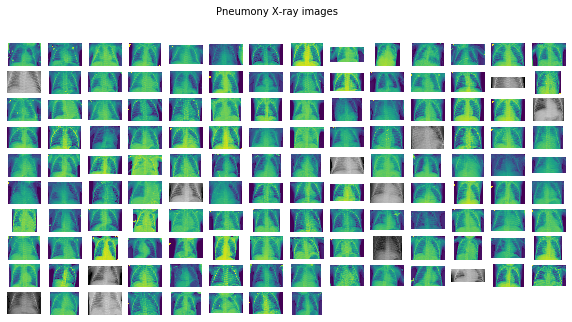

In [31]:
plots_from_files(pneumo_images, rows=10, maintitle="Pneumony X-ray images")

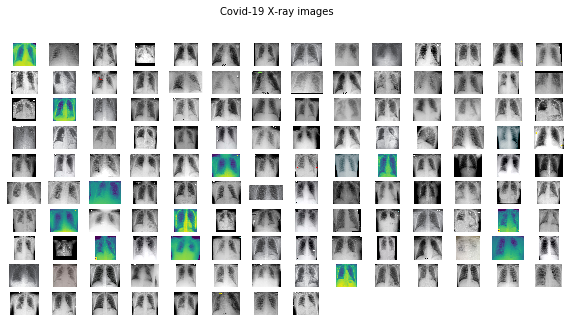

In [32]:
plots_from_files(covid_images, rows=10, maintitle="Covid-19 X-ray images")

In [33]:
validation_path = '../dataset_validation'
normal_val_images = list(paths.list_images(
    f"{validation_path}/normal_validation"))
non_covid_pneumonia_validation_images = list(paths.list_images(
    f"{validation_path}/non_covid_pneumonia_validation"))
covid_val_images = list(paths.list_images(
    f"{validation_path}/covid_validation"))

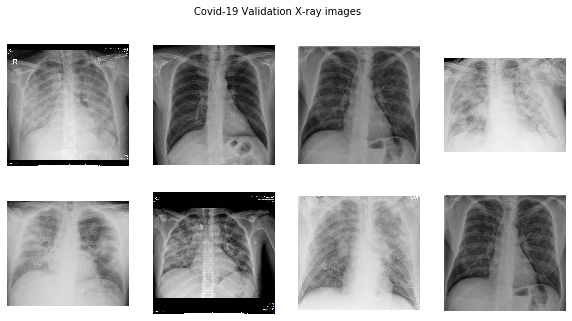

In [34]:
plots_from_files(covid_val_images, rows=2, maintitle="Covid-19 Validation X-ray images")

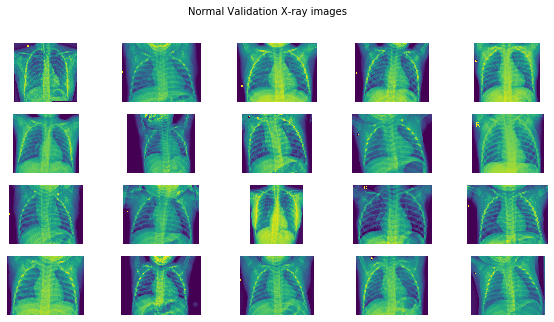

In [35]:
plots_from_files(normal_val_images, rows=4, maintitle="Normal Validation X-ray images")

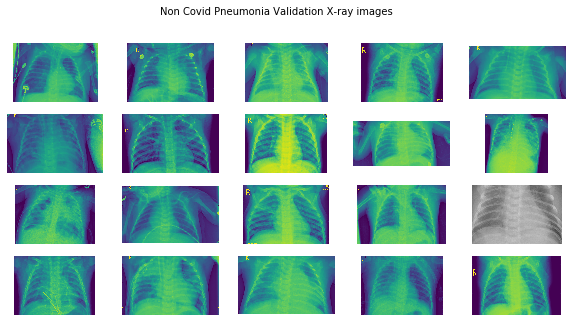

In [36]:
plots_from_files(non_covid_pneumonia_validation_images, rows=4, maintitle="Non Covid Pneumonia Validation X-ray images")

## Data preprocessing

### Initializing hyperparameters

In [43]:
ROTATION_DEG = 15      # [10]
SPLIT = 0.2            # [0.1]

In [37]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...", end = '')
imagePaths = list(paths.list_images(dataset_path))
print("[Done]")

[INFO] loading images...[Done]


In [38]:
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [39]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [40]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [42]:
# partition the data into training and testing 
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=SPLIT,
                                                  stratify=labels,
                                                  random_state=42)

In [44]:
# Data augmentation against Overfiffing
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=ROTATION_DEG, fill_mode="nearest")

## Model

In [45]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [46]:
# initialize the initial learning rate, number of epochs to train and batch size
INIT_LR = 0.0001         # [0.00001]
EPOCHS = 20            # [200]
BS = 16                 # [16, 32]
NODES_DENSE0 = 128      # [128]
DROPOUT = 0.5          # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
MAXPOOL_SIZE = (2, 2)  # [(2,2) , (3,3)]

In [47]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=MAXPOOL_SIZE)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(NODES_DENSE0, activation="relu")(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [48]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

### Training

In [49]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [50]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
  ...
    to  
  ['...']
Train for 13 steps, validate on 54 samples
Epoch 1/20
13/13 [==============================] - 30s 2s/step - loss: 0.7149 - accuracy: 0.5960 - val_loss: 0.4822 - val_accuracy: 0.9167
Epoch 2/20
13/13 [==============================] - 32s 2s/step - loss: 0.5230 - accuracy: 0.7576 - val_loss: 0.3824 - val_accuracy: 0.9583
Epoch 3/20
13/13 [==============================] - 31s 2s/step - loss: 0.4409 - accuracy: 0.8333 - val_loss: 0.3109 - val_accuracy: 0.9792
Epoch 4/20
13/13 [==============================] - 30s 2s/step - loss: 0.4021 - accuracy: 0.8687 - val_loss: 0.2608 - val_accuracy: 0.9375
Epoch 5/20
13/13 [==============================] - 31s 2s/step - loss: 0.3144 - accuracy: 0.9141 - val_loss: 0.2270 - val_accuracy: 0.9583
Epoch 6/20
13/13 [==============================] - 31s 2s/step - loss: 0.2683 - accuracy: 0.9040 - val_loss: 0.1967 - val_accuracy: 0.9375
Epoch 7/20
13/13 [==============================] - 33s 3s/step - lo

### Plot trining metrics

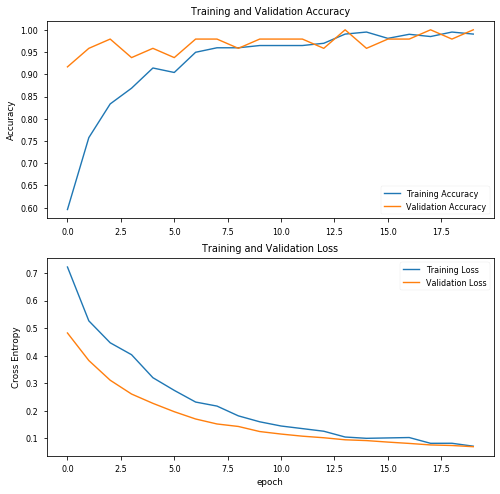

In [52]:
plot_accuraccy(H)

### Evaluation

In [53]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.96      1.00      0.98        27
      pneumo       1.00      0.96      0.98        27

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



#### Confusion matrix

In [54]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[27  0]
 [ 1 26]]
acc: 0.9815
sensitivity: 1.0000
specificity: 0.9630


## Fine Tunning the model

### changing Hyperparameters

In [61]:
# initialize the initial learning rate, number of epochs to train and batch size
INIT_LR = 0.0001         # [0.00001]
EPOCHS = 20            # [200]
BS = 16                 # [16, 32]
NODES_DENSE0 = 128      # [128]
DROPOUT = 0.5          # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
MAXPOOL_SIZE = (2, 2)  # [(2,2) , (3,3)]
ROTATION_DEG = 10      # [10]
SPLIT = 0.1            # [0.1]

In [62]:
# partition the data into training and testing 
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=SPLIT,
                                                  stratify=labels,
                                                  random_state=42)

trainAug = ImageDataGenerator(rotation_range=ROTATION_DEG, fill_mode="nearest")

In [63]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=MAXPOOL_SIZE)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(NODES_DENSE0, activation="relu")(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

### Compiling & Training

In [64]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
Train for 15 steps, validate on 27 samples
Epoch 1/20
15/15 [==============================] - 27s 2s/step - loss: 0.8117 - accuracy: 0.5644 - val_loss: 0.2876 - val_accuracy: 0.9375
Epoch 2/20
15/15 [==============================] - 28s 2s/step - loss: 0.5271 - accuracy: 0.7156 - val_loss: 0.2615 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 28s 2s/step - loss: 0.4826 - accuracy: 0.7556 - val_loss: 0.1915 - val_accuracy: 0.9375
Epoch 4/20
15/15 [==============================] - 28s 2s/step - loss: 0.4025 - accuracy: 0.8356 - val_loss: 0.1804 - val_accuracy: 1.0000
Epoch 5/20
15/15 [==============================] - 29s 2s/step - loss: 0.3173 - accuracy: 0.8978 - val_loss: 0.1357 - val_accuracy: 0.9375
Epoch 6/20
15/15 [==============================] - 29s 2s/step - loss: 0.2694 - accuracy: 0.9289 - val_loss: 0.1284 - val_accuracy: 1.0000
Epoch 7/20
15/15 [========================

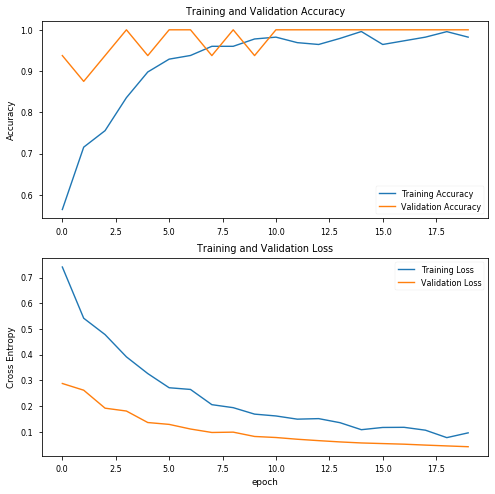

In [65]:
plot_accuraccy(H)

In [66]:
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(
    classification_report(testY.argmax(axis=1),
                          predIdxs,
                          target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        13
      pneumo       1.00      1.00      1.00        14

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [67]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("\nacc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[13  0]
 [ 0 14]]

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


Now save the model

In [68]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save("../model/covid_pneumo_model.h5")

Test loaded model

In [71]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('../model/covid_pneumo_model.h5')

# Show the model architecture
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [72]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        13
      pneumo       1.00      1.00      1.00        14

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



## Testing model with Real images

### Test on Covid images (From March/2020)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


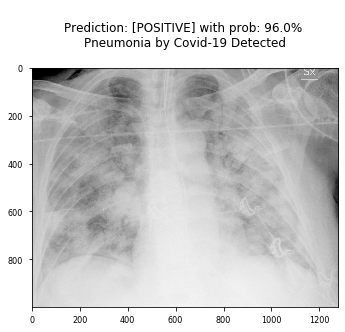

In [73]:
imagePath = '../dataset_validation/covid_validation/6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


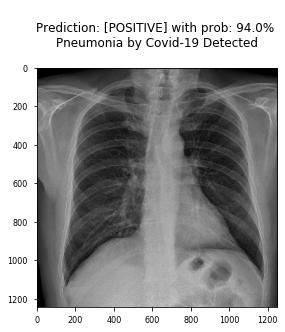

In [74]:
imagePath = '../dataset_validation/covid_validation/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


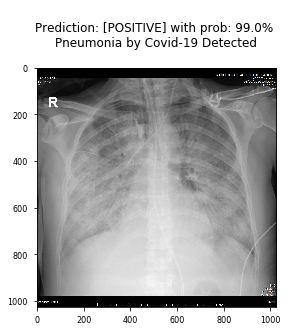

In [75]:
imagePath = '../dataset_validation/covid_validation/31BA3780-2323-493F-8AED-62081B9C383B.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


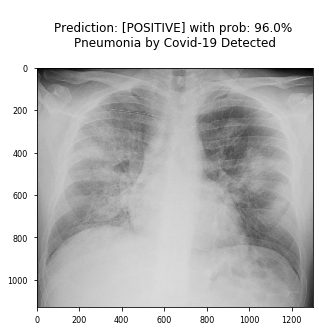

In [76]:
imagePath = '../dataset_validation/covid_validation/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


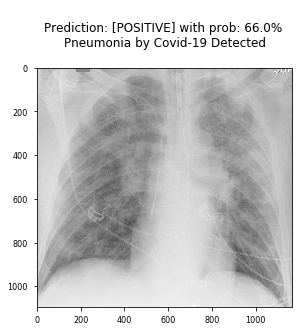

In [77]:
imagePath = '../dataset_validation/covid_validation/B2D20576-00B7-4519-A415-72DE29C90C34.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


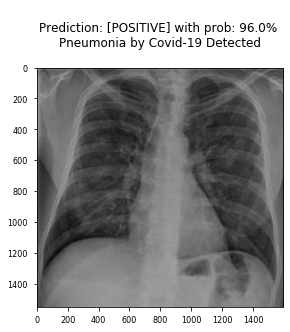

In [78]:
imagePath = '../dataset_validation/covid_validation/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


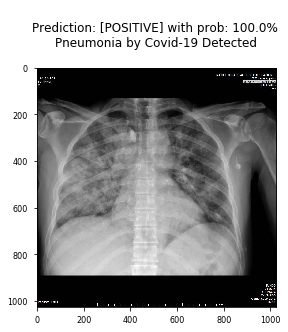

In [79]:
imagePath = '../dataset_validation/covid_validation/F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


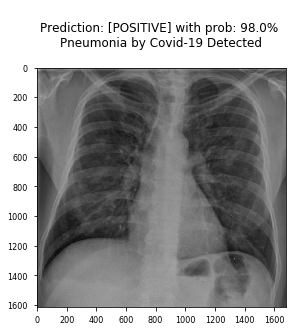

In [80]:
imagePath = '../dataset_validation/covid_validation/F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg'
pred = test_rx_image_for_Covid19(imagePath)

### Testing on normal images:


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


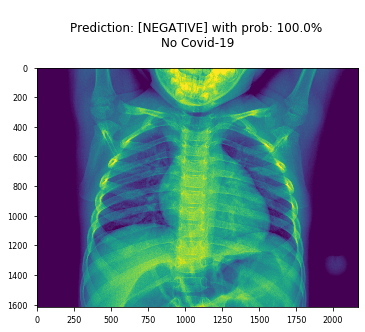

In [97]:
imagePath = '../dataset_validation/normal_validation/IM-0177-0001.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


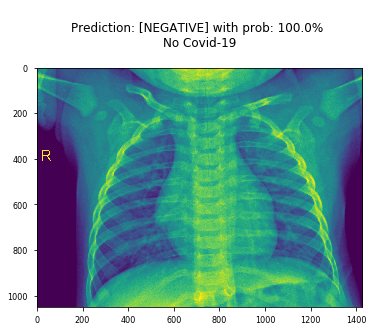

In [98]:
imagePath = '../dataset_validation/normal_validation/IM-0207-0001.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


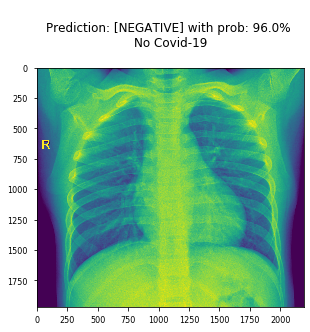

In [99]:
imagePath = '../dataset_validation/normal_validation/IM-0656-0001-0001.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


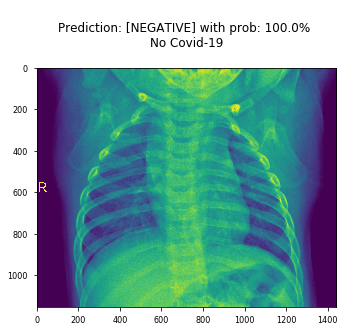

In [100]:
imagePath = '../dataset_validation/normal_validation/NORMAL2-IM-0500-0001.jpeg'
pred = test_rx_image_for_Covid19(imagePath)

### Testing With Non Covid - Pneumonia


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


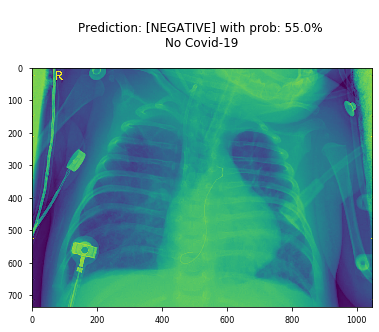

In [101]:
imagePath = '../dataset_validation/non_covid_pneumonia_validation/person63_bacteria_306.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


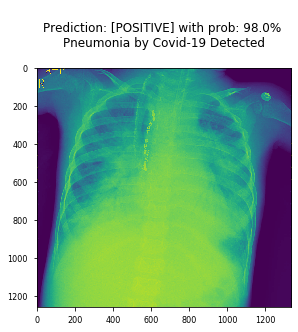

In [102]:
imagePath = '../dataset_validation/non_covid_pneumonia_validation/person124_virus_238.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


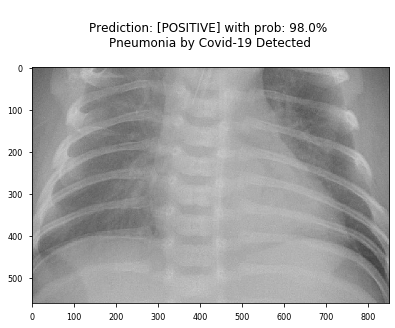

In [103]:
imagePath = '../dataset_validation/non_covid_pneumonia_validation/person69_bacteria_338.jpeg'
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


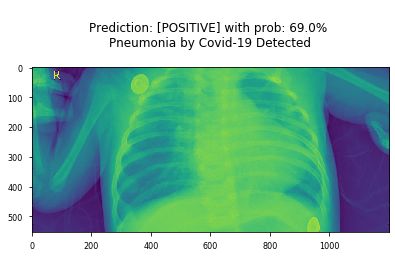

In [104]:
imagePath = '../dataset_validation/non_covid_pneumonia_validation/person26_bacteria_122.jpeg'
pred = test_rx_image_for_Covid19(imagePath)

### Validation in Batches

In [81]:
covid_val_images

['../dataset_validation/covid_validation/31BA3780-2323-493F-8AED-62081B9C383B.jpeg',
 '../dataset_validation/covid_validation/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg',
 '../dataset_validation/covid_validation/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg',
 '../dataset_validation/covid_validation/6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg',
 '../dataset_validation/covid_validation/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg',
 '../dataset_validation/covid_validation/F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg',
 '../dataset_validation/covid_validation/B2D20576-00B7-4519-A415-72DE29C90C34.jpeg',
 '../dataset_validation/covid_validation/F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg']

In [82]:
img_lst = covid_val_images
covid_predictions_score, covid_neg_cnt, covid_pos_cnt = test_rx_image_for_Covid19_batch(img_lst)
covid_predictions_score

8 positive detected in a total of 8 images


[0.9876089,
 0.9374398,
 0.9620035,
 0.9604324,
 0.9643773,
 0.99664235,
 0.6559531,
 0.9750871]

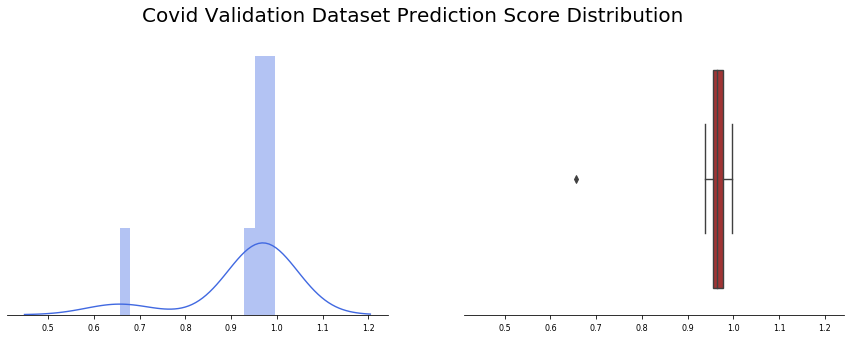

In [83]:
dist = covid_predictions_score
plot_prediction_distribution(dist, "Covid Validation Dataset Prediction Score Distribution")

In [84]:
print ('Covid Validation Dataset Prediction Score Mean: ',stat.mean(dist))
print ('Covid Validation Dataset Prediction Score Median: ',stat.median(dist))

Covid Validation Dataset Prediction Score Mean:  0.9299431
Covid Validation Dataset Prediction Score Median:  0.9631904363632202


In [85]:
img_lst = normal_val_images
normal_predictions_score, normal_neg_cnt, normal_pos_cnt = test_rx_image_for_Covid19_batch(
    img_lst)
normal_predictions_score

2 positive detected in a total of 20 images


[0.8238383,
 0.043901376,
 0.032107744,
 0.008960635,
 0.16069078,
 0.31498072,
 0.17280851,
 0.020119911,
 0.011529922,
 0.01665964,
 0.0058929008,
 0.0067560645,
 0.88187313,
 0.0124913175,
 0.010061421,
 0.021609545,
 0.0053640665,
 0.012977176,
 0.05783088,
 0.03891901]

### Testing with "Chest Test dataset"

In [87]:
validation_path = '../input/20_Chest_Xray/test'

normal_test_val_images = list(paths.list_images(f"{validation_path}/NORMAL"))
print("Normal Xray Images: ", len(normal_test_val_images))

pneumo_test_val_images = list(paths.list_images(f"{validation_path}/PNEUMONIA"))
print("Pneumo Xray Images: ", len(pneumo_test_val_images))

Normal Xray Images:  234
Pneumo Xray Images:  390


**Pneumo**

In [88]:
pneumo_test_predictions_score, pneumo_test_neg_cnt, pneumo_test_pos_cnt = test_rx_image_for_Covid19_batch(
    pneumo_test_val_images)

3 positive detected in a total of 390 images


In [90]:
print("False Positives: {}%".format(round((pneumo_test_pos_cnt /
                                           (pneumo_test_pos_cnt + pneumo_test_neg_cnt))*100, 2)))

False Positives: 0.77%


In [91]:
stat.mean(pneumo_test_predictions_score)

0.036197912

In [92]:
stat.median(pneumo_test_predictions_score)

0.019426420331001282

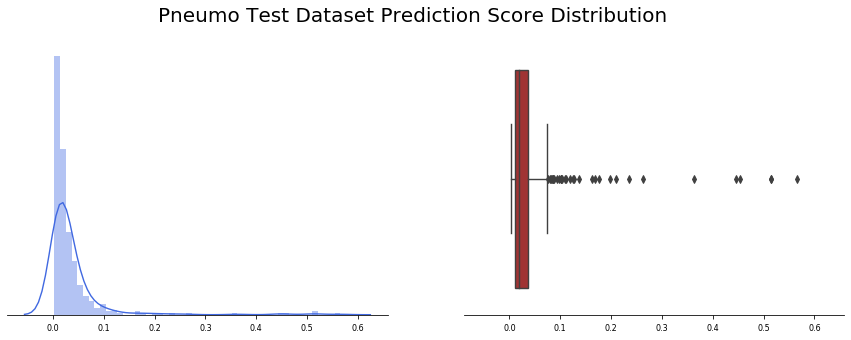

In [93]:
dist = pneumo_test_predictions_score
plot_prediction_distribution(pneumo_test_predictions_score, "Pneumo Test Dataset Prediction Score Distribution")

**Normal**

In [94]:
normal_test_predictions_score, normal_test_neg_cnt, normal_test_pos_cnt = test_rx_image_for_Covid19_batch(
    normal_test_val_images)

45 positive detected in a total of 234 images


In [95]:
stat.mean(normal_test_predictions_score)

0.19427028

In [96]:
stat.median(normal_test_predictions_score)

0.0310348067432642

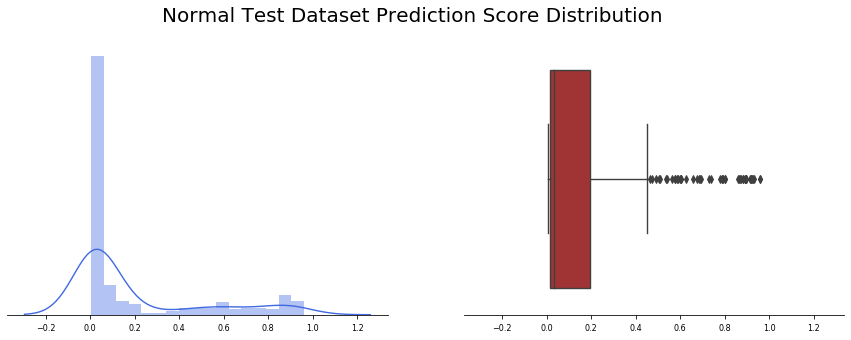

In [97]:
dist = normal_test_predictions_score
plot_prediction_distribution(dist, "Normal Test Dataset Prediction Score Distribution")